In [17]:
import ipywidgets as widgets
from HARK.ConsumptionSaving.ConsPortfolioModel import SequentialPortfolioConsumerType
from HARK.utilities import plot_funcs

from simulate.parameters import LUCAS0
import math
import matplotlib.pyplot as plt
import numpy as np

In [46]:
LUCAS0["aNrmInitStd"] = 0.0

risky_expectations = {"RiskyAvg": 1.0175492133848216, "RiskyStd": 0.09283741339989003}

parameter_dict = LUCAS0.copy()

parameter_dict['PermShkStd'] = [.1]

parameter_dict.update(risky_expectations)

PARAMS = parameter_dict  # a0h.parameters

PARAMS["aNrmInitMean"] = 1
PARAMS["aNrmInitStd"] = 0.00
PARAMS["T_sim"] = 5000
PARAMS["PermGroFac"] = [PARAMS["PermGroFac"]]
PARAMS["AgentCount"] = 2000
PARAMS["sim_common_Rrisky"] = False

# PARAMS['LivPrb'] = [1.0]
PARAMS["DiscFac"] = 0.99  # * 0.995 * .9

# PARAMS['TranShkStd'] = [1.0]

PARAMS["RiskyCount"] = 9


at = SequentialPortfolioConsumerType(**PARAMS)
at.track_vars += ["aNrm", "cNrm", "mNrm", "Risky", "Share", "aLvl", "pLvl"]
at.solve()

cFunc = at.solution[0].cFuncAdj
ShareFunc = at.solution[0].ShareFuncAdj

In [47]:
parameter_dict

{'cycles': 0,
 'aNrmInitStd': 0.0,
 'aNrmInitMean': 1,
 'LivPrb': [0.9949620563926881],
 'PermGroFac': [1.0],
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'Rfree': 1.0,
 'TranShkStd': [0],
 'PermShkStd': [0.1],
 'UnempPrb': 0.0,
 'CRRA': 3,
 'DiscFac': 0.99,
 'ex_post': None,
 'AgentCount': 2000,
 'num_per_type': 1000,
 'RiskyAvg': 1.0175492133848216,
 'RiskyStd': 0.09283741339989003,
 'T_sim': 5000,
 'sim_common_Rrisky': False,
 'RiskyCount': 9}

In [48]:
agent_parameters = PARAMS.copy()

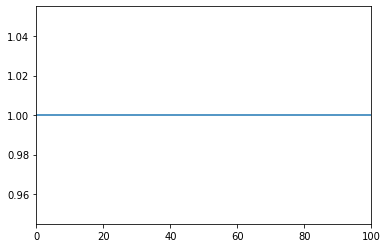

In [49]:
plot_funcs(ShareFunc, 0, 100)

In [50]:
dividend_growth_rate = 1.000203
dividend_std = 0.011983

def price_dividend_ratio_random_walk(
    DiscFac, CRRA, days_per_quarter=90
):

    # Assuming DiscFac in argument in quarterly
    DiscFac_daily = DiscFac ** (1.0 / days_per_quarter)

    dividend_shock_std = dividend_std / math.sqrt(dividend_growth_rate)

    subjective_return = (
        dividend_growth_rate ** (1 - CRRA)
        * DiscFac_daily
        * (dividend_shock_std**2 + 1) ** (CRRA * (CRRA - 1) / 2)
    )

    print("subjective_return: " + str(subjective_return))
    return subjective_return < 1

In [53]:
def portfolio_choice(CRRA=6.0, DiscFac=0.9):
    agent_parameters["CRRA"] = CRRA
    agent_parameters["DiscFac"] = DiscFac

    print("Solving...")

    agent = SequentialPortfolioConsumerType(**agent_parameters)
    agent.solve()

    print("Solved!")
    
    srle1 = price_dividend_ratio_random_walk(DiscFac, CRRA)
    
    print("subjective_return < 1?: " + str(srle1))

    plot_funcs(agent.solution[0].ShareFuncAdj, 0, 100)
    
    plot_funcs(agent.solution[0].cFuncAdj, 0, 100)
    
    cFunc = agent.solution[0].cFuncAdj
    ShareFunc = agent.solution[0].ShareFuncAdj
    
    def expected_increase(mNrm):
        share = ShareFunc(mNrm)

        aNrm = mNrm - cFunc(mNrm)

        mNrm_next = (
            aNrm
            * (share * agent.parameters["RiskyAvg"] + (1 - share) * agent.parameters["Rfree"])
            + 1
        )
    
        gain = mNrm_next - aNrm

        return gain
    
    mNrm = np.linspace(0, 20, 1000)

    plt.plot(mNrm, cFunc(mNrm), label="c")

    plt.plot(mNrm, expected_increase(mNrm), label="gain")

    plt.plot(mNrm, (mNrm - cFunc(mNrm)) * ShareFunc(mNrm), label ="wealth-into-market" )
    
    plt.legend()

In [54]:
widgets.interact(
    portfolio_choice,
    CRRA=(2, 10, 1),
    DiscFac=(0.5, 0.99, 0.02),
    continuous_update=False,
)

interactive(children=(IntSlider(value=6, description='CRRA', max=10, min=2), FloatSlider(value=0.9, descriptio…

<function __main__.portfolio_choice(CRRA=6.0, DiscFac=0.9)>

Questions:

- How can we compute the `E[aNrm[t-1]]` values from a given `mNrm[t]`, such that we can go from the consumption/expected gain intercept to an equilibrium normalized asset value?
  
- What we need for the SHARKFin economy to be at equilibrium is for the consumers to have a finite equilibium _level_ of assets (not normalized by labor income). How to do we compute it when permanent labor income is following a random walk?